## 2026 EY AI & Data Challenge - Landsat Data Extraction Notebook

This notebook demonstrates Landsat data extraction and the creation of an output file to be used by the benchmark notebook. The baseline data is [Landsat Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data from the MS Planetary Computer catalog.

**Caution**... This notebook requires significant execution time as there are 9,319 data points (unique locations and times) used for data extraction from the Landsat archive. The code takes about 7 hours to run to completion on a typical laptop computer with a typical internet connection. Lower execution times are likely possible with optimization of the data extraction process and the use of cloud computing services.


In [ ]:
# !pip install uv
# !uv pip install  -r ../requirements.txt

In [1]:
import time
# import snowflake
# from snowflake.snowpark.context import get_active_session
# session = get_active_session()

import warnings

from matplotlib.pyplot import title

warnings.filterwarnings("ignore")

# Data manipulation and analysis
import numpy as np
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


## Pre-processing

In [2]:
Water_Quality_df=pd.read_csv('../water_quality_training_dataset.csv')
display(Water_Quality_df.head())

Latitude  Longitude Sample Date  Total Alkalinity  Electrical Conductance  \
0 -28.760833  17.730278  02-01-2011           128.912                   555.0   
1 -26.861111  28.884722  03-01-2011            74.720                   162.9   
2 -26.450000  28.085833  03-01-2011            89.254                   573.0   
3 -27.671111  27.236944  03-01-2011            82.000                   203.6   
4 -27.356667  27.286389  03-01-2011            56.100                   145.1   

   Dissolved Reactive Phosphorus  
0                           10.0  
1                          163.0  
2                           80.0  
3                          101.0  
4                          151.0

In [3]:
geometry = [Point(xy) for xy in zip(Water_Quality_df['Longitude'], Water_Quality_df['Latitude'])]
gdf = gpd.GeoDataFrame(Water_Quality_df, geometry=geometry, crs="EPSG:4326")

In [4]:
scaler = MinMaxScaler()
Water_Quality_df[["ta_norm", "ec_norm", "drp_norm"]] = scaler.fit_transform(Water_Quality_df[["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]])
gdf[["ta_norm", "ec_norm", "drp_norm"]] = scaler.fit_transform(gdf[["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]])

## Map Plots

In [32]:
def plot_columns_on_map(gdf, columns, vmin=None, vmax=None):
    gdf_web = gdf.to_crs(epsg=3857)
    fig, axes = plt.subplots(1, len(columns), figsize=(18, 6))
    for ax, column in zip(axes, columns):
        gdf_web.plot(
            column=column,
            cmap="RdYlGn_r",
            legend=True,
            vmin=vmin,
            vmax=vmax,
            markersize=20,
            ax=ax
        )
        ax.set_title(column)
        ax.set_axis_off()

        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    plt.tight_layout()
    plt.show()

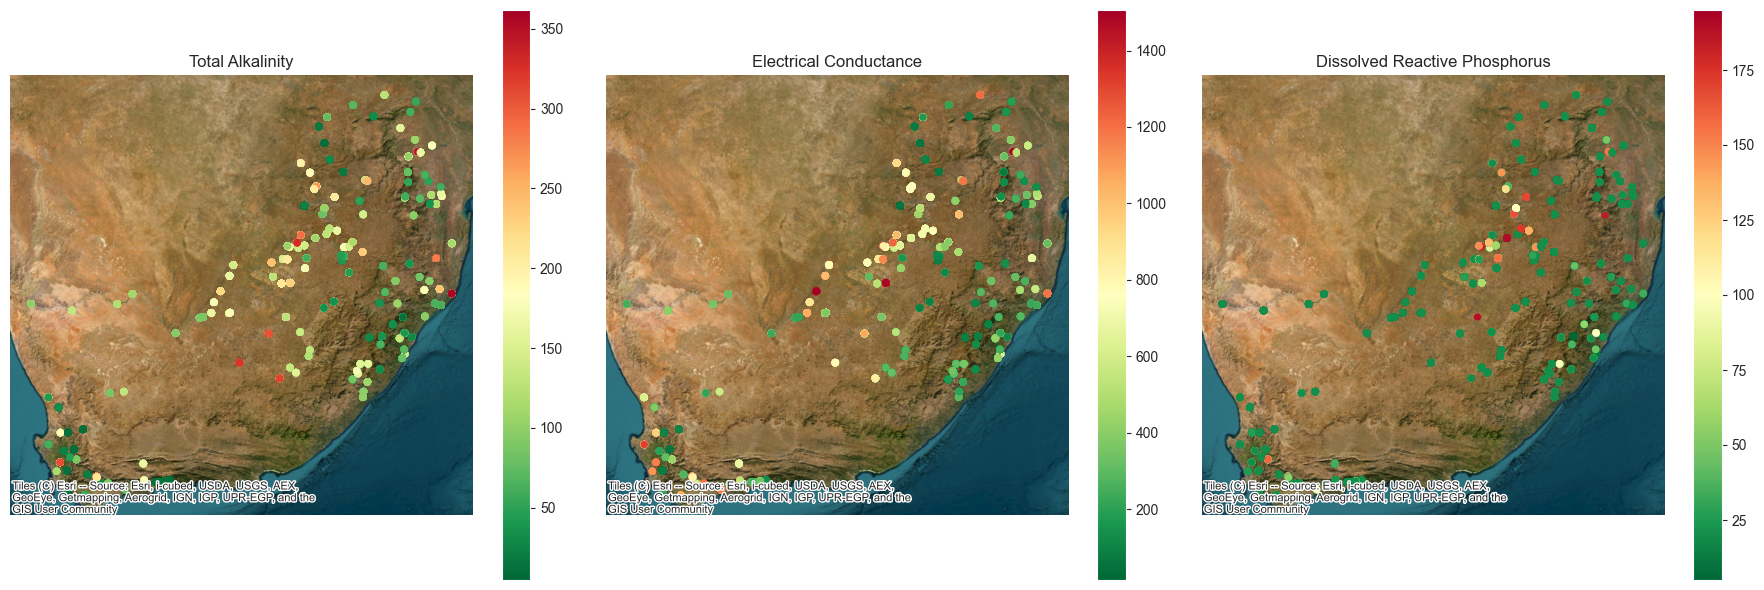

In [33]:
columns = ["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]
plot_columns_on_map(gdf, columns)

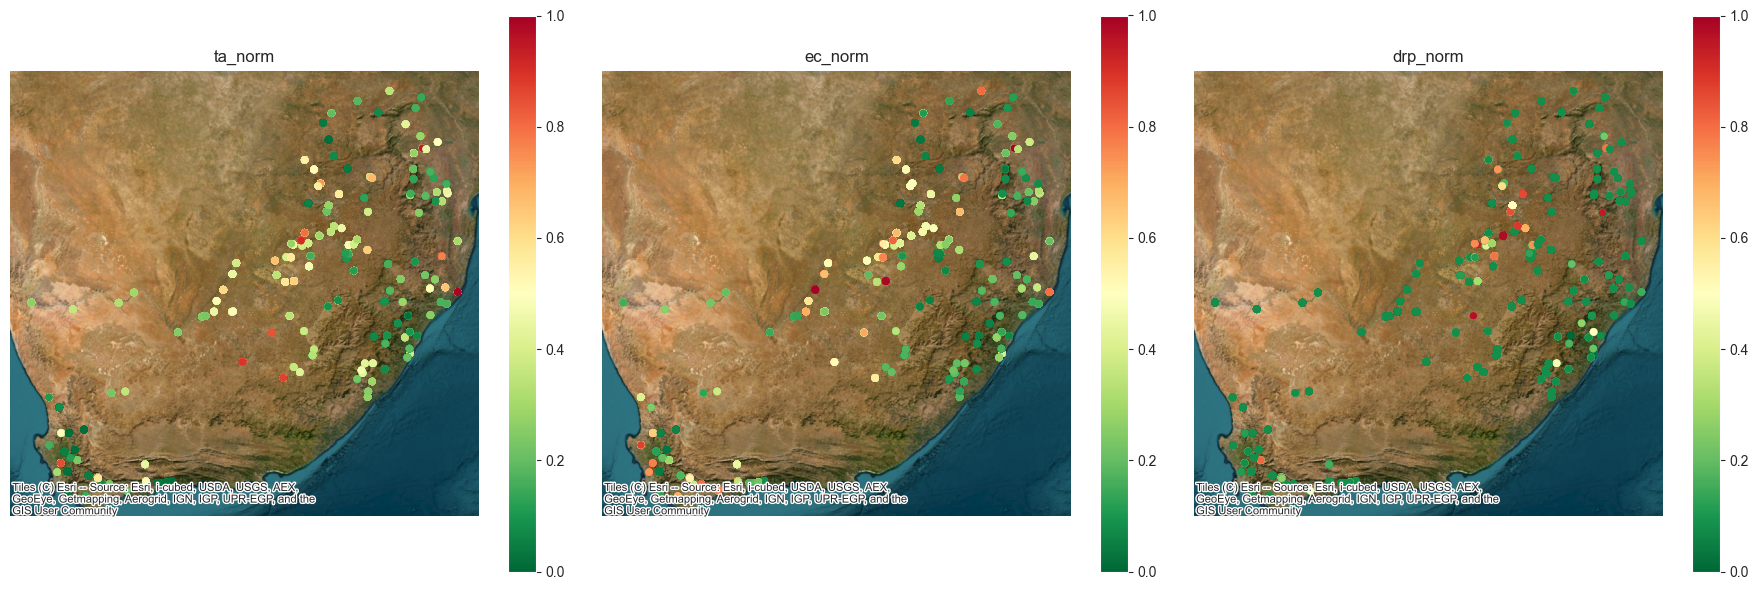

In [34]:
columns = ["ta_norm", "ec_norm", "drp_norm"]
plot_columns_on_map(gdf, columns)

## How many samples are there per location?

In [14]:
sample_tuples = []
for long, lat in Water_Quality_df[['Longitude', 'Latitude']].drop_duplicates().itertuples(index=False):
    location_samples = Water_Quality_df[(Water_Quality_df['Longitude']==long) & (Water_Quality_df['Latitude']==lat)].sort_values("Sample Date", ascending=True)
    sample_tuples.append((long, lat, len(location_samples)))

df_sample_tuples = pd.DataFrame(sample_tuples, columns=["Longitude", "Latitude", "Num Samples"]).sort_values("Num Samples")
display(df_sample_tuples)

Longitude   Latitude  Num Samples
151  18.616917 -33.722667            6
115  31.123611 -24.034167            7
159  29.395278 -24.958611            7
125  28.898056 -22.548889            9
129  31.516667 -24.967500           10
..         ...        ...          ...
16   27.089444 -26.648056          178
49   26.965000 -26.880278          182
5    26.698083 -27.010111          185
17   27.211111 -26.970278          187
9    26.632278 -26.984722          210

[162 rows x 3 columns]

## How do samples vary across date for a given location?

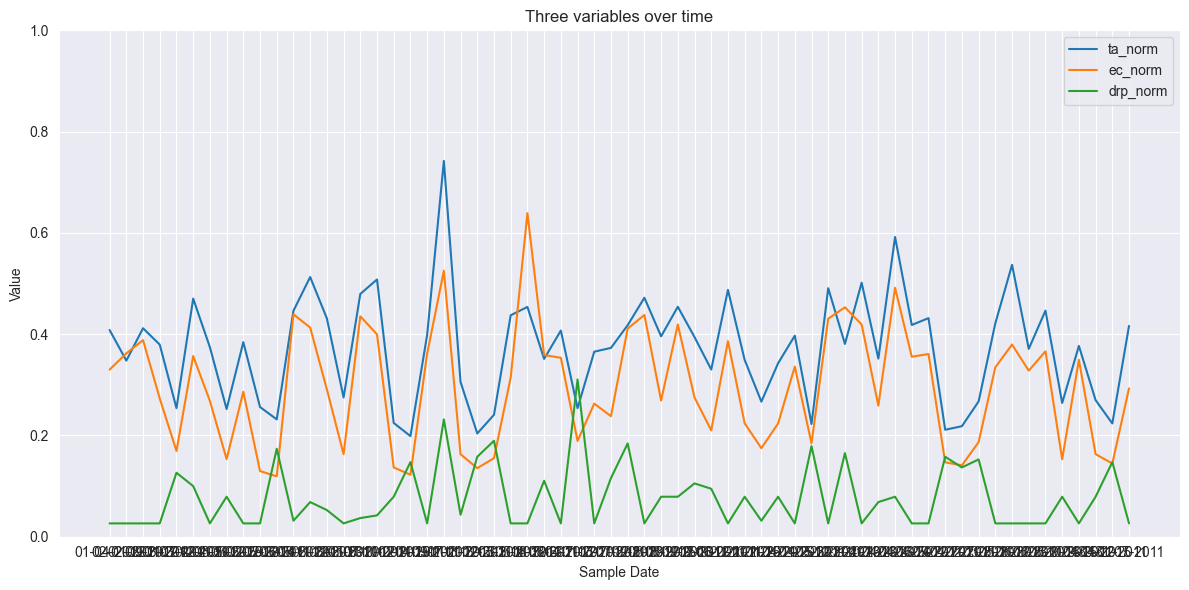

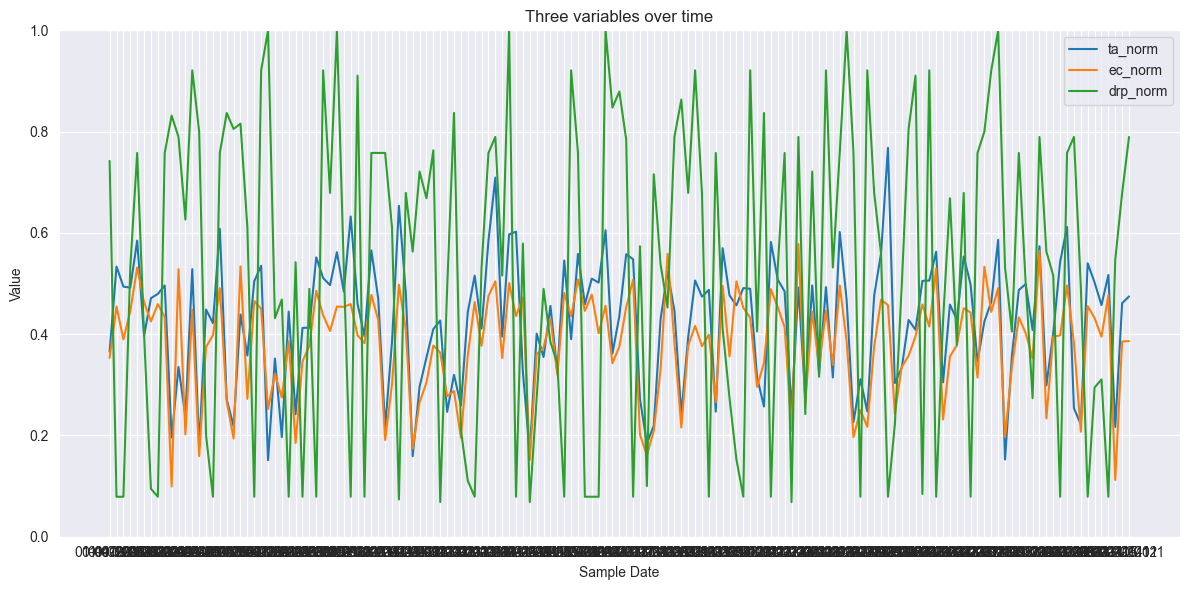

In [15]:
iterations = 2
counter = 0
for long, lat in Water_Quality_df[['Longitude', 'Latitude']].drop_duplicates().itertuples(index=False):
    counter += 1
    location_samples = Water_Quality_df[(Water_Quality_df['Longitude']==long) & (Water_Quality_df['Latitude']==lat)].sort_values("Sample Date", ascending=True)

    plt.figure(figsize=(12, 6))

    plt.plot(location_samples["Sample Date"], location_samples["ta_norm"], label="ta_norm")
    plt.plot(location_samples["Sample Date"], location_samples["ec_norm"], label="ec_norm")
    plt.plot(location_samples["Sample Date"], location_samples["drp_norm"], label="drp_norm")

    plt.ylim(0, 1)  # lock y-axis between 0 and 1
    plt.xlabel("Sample Date")
    plt.ylabel("Value")
    plt.title("Three variables over time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if counter == iterations:break



## Coefficient of Variation for each sample location
The coefficient of variation (CV) is a unitless statistical measure of relative dispersion, calculated as the ratio of the standard deviation to the mean, typically expressed as a percentage.
It is used to compare the variability of datasets with different units or vastly different means.

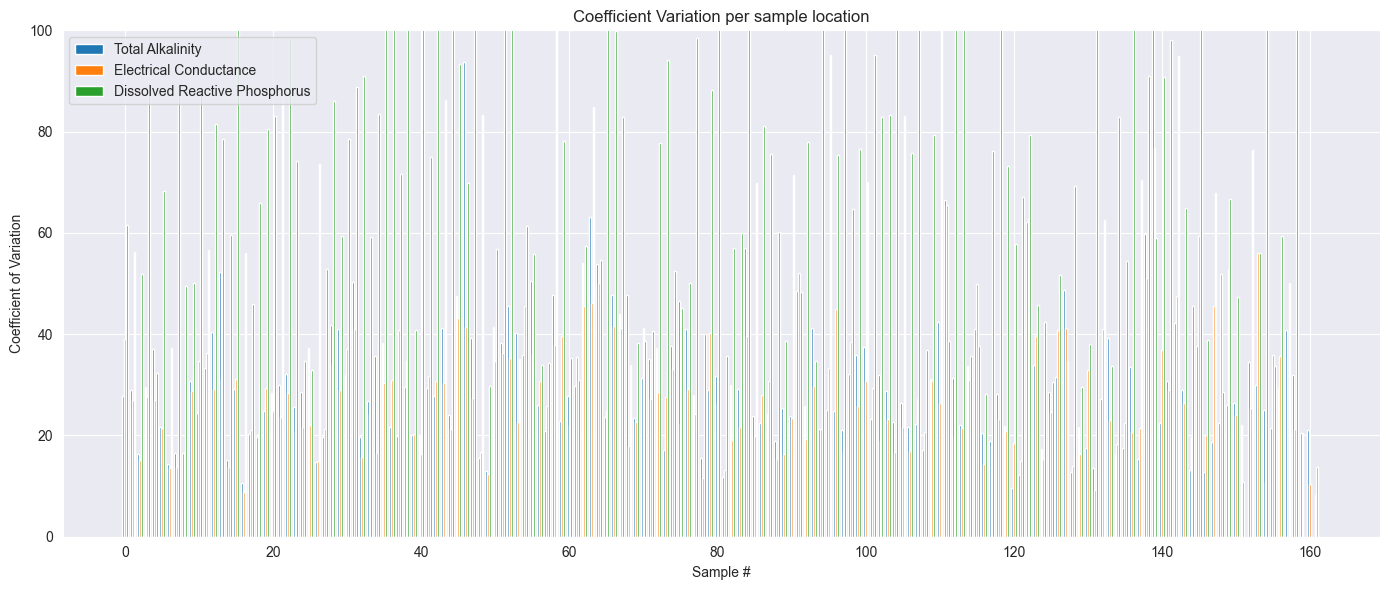

In [16]:
coefficient_variations = []
for long, lat in Water_Quality_df[['Longitude', 'Latitude']].drop_duplicates().itertuples(index=False):
    counter += 1
    location_samples = Water_Quality_df[(Water_Quality_df['Longitude']==long) & (Water_Quality_df['Latitude']==lat)].sort_values("Sample Date", ascending=True)
    # coefficient_variations.append((
    #     location_samples["ta_norm"].std() / location_samples["ta_norm"].mean()
    #     , location_samples["ec_norm"].std() / location_samples["ec_norm"].mean()
    #     , location_samples["drp_norm"].std() / location_samples["drp_norm"].mean()
    # ))

    coefficient_variations.append((
        (location_samples["Total Alkalinity"].std() / location_samples["Total Alkalinity"].mean()) * 100
        , (location_samples["Electrical Conductance"].std() / location_samples["Electrical Conductance"].mean()) * 100
        , (location_samples["Dissolved Reactive Phosphorus"].std() / location_samples["Dissolved Reactive Phosphorus"].mean()) * 100
    ))

arr = np.array(coefficient_variations)
n = len(arr)
x = np.arange(n)

width = 0.25

plt.figure(figsize=(14, 6))

plt.bar(x - width, arr[:,0], width, label="Total Alkalinity")
plt.bar(x,         arr[:,1], width, label="Electrical Conductance")
plt.bar(x + width, arr[:,2], width, label="Dissolved Reactive Phosphorus")

plt.ylim(0, 100)
plt.xlabel("Sample #")
plt.ylabel("Coefficient of Variation")
plt.title("Coefficient Variation per sample location")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
coefficient_variations = []
for long, lat in Water_Quality_df[['Longitude', 'Latitude']].drop_duplicates().itertuples(index=False):
    counter += 1
    location_samples = Water_Quality_df[(Water_Quality_df['Longitude']==long) & (Water_Quality_df['Latitude']==lat)].sort_values("Sample Date", ascending=True)
    # coefficient_variations.append((
    #     location_samples["ta_norm"].std() / location_samples["ta_norm"].mean()
    #     , location_samples["ec_norm"].std() / location_samples["ec_norm"].mean()
    #     , location_samples["drp_norm"].std() / location_samples["drp_norm"].mean()
    # ))

    coefficient_variations.append((
        long
        , lat
        , (location_samples["Total Alkalinity"].std() / location_samples["Total Alkalinity"].mean()) * 100
        , (location_samples["Electrical Conductance"].std() / location_samples["Electrical Conductance"].mean()) * 100
        , (location_samples["Dissolved Reactive Phosphorus"].std() / location_samples["Dissolved Reactive Phosphorus"].mean()) * 100
    ))

df_coef_v = pd.DataFrame(coefficient_variations, columns=['Longitude', 'Latitude', "ta_cv", "ec_cv", "drp_cv"])
df_coef_v

Longitude   Latitude      ta_cv      ec_cv      drp_cv
0    17.730278 -28.760833  27.884027  39.002560   61.479854
1    28.884722 -26.861111  29.067948  26.924201   56.185109
2    28.085833 -26.450000  16.302875  15.142251   51.901517
3    27.236944 -27.671111  29.660460  27.635383   89.853304
4    27.286389 -27.356667  37.117346  27.099782   32.389046
..         ...        ...        ...        ...         ...
157  18.750556 -32.601389  40.834044   0.000000   50.136097
158  31.902500 -28.308889  31.951203  21.310380  124.296562
159  29.395278 -24.958611  20.398259  20.417720    0.000000
160  27.980833 -26.619444  21.018542  10.379175    0.000000
161  28.351389 -26.510278   8.240474  13.804920    0.000000

[162 rows x 5 columns]

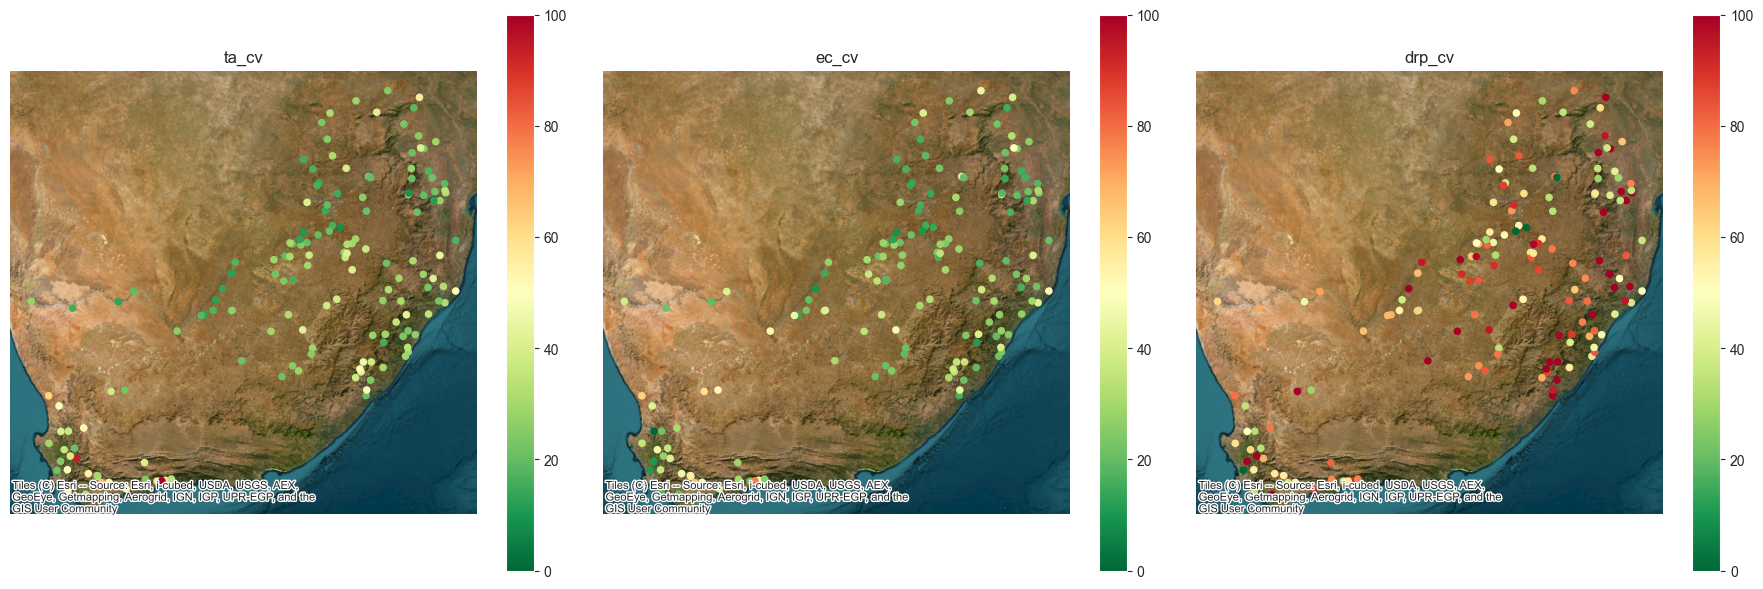

In [35]:
geometry_cv = [Point(xy) for xy in zip(df_coef_v['Longitude'], df_coef_v['Latitude'])]
gdf_cv = gpd.GeoDataFrame(df_coef_v, geometry=geometry_cv, crs="EPSG:4326")
plot_columns_on_map(gdf_cv, ["ta_cv", "ec_cv", "drp_cv"], vmin=0, vmax=100)

## TA, EC & DRP per day over time (Try and identify seasonal variations)

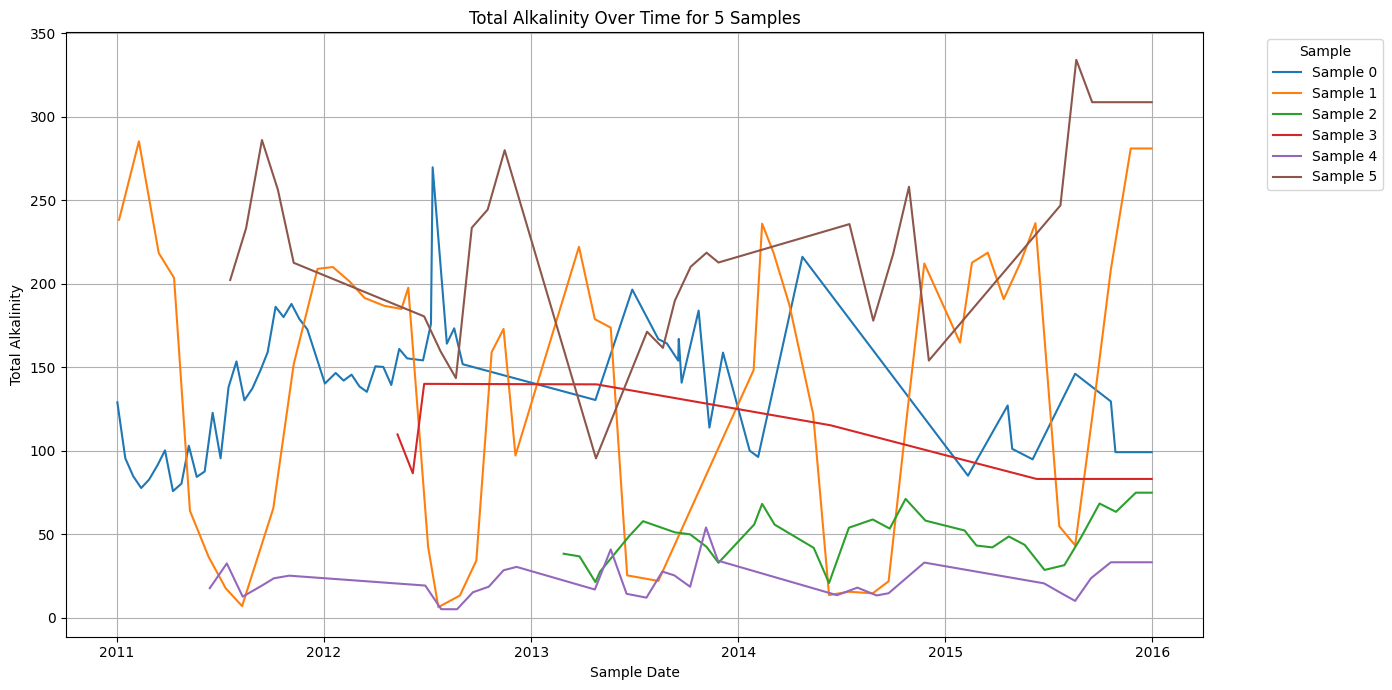

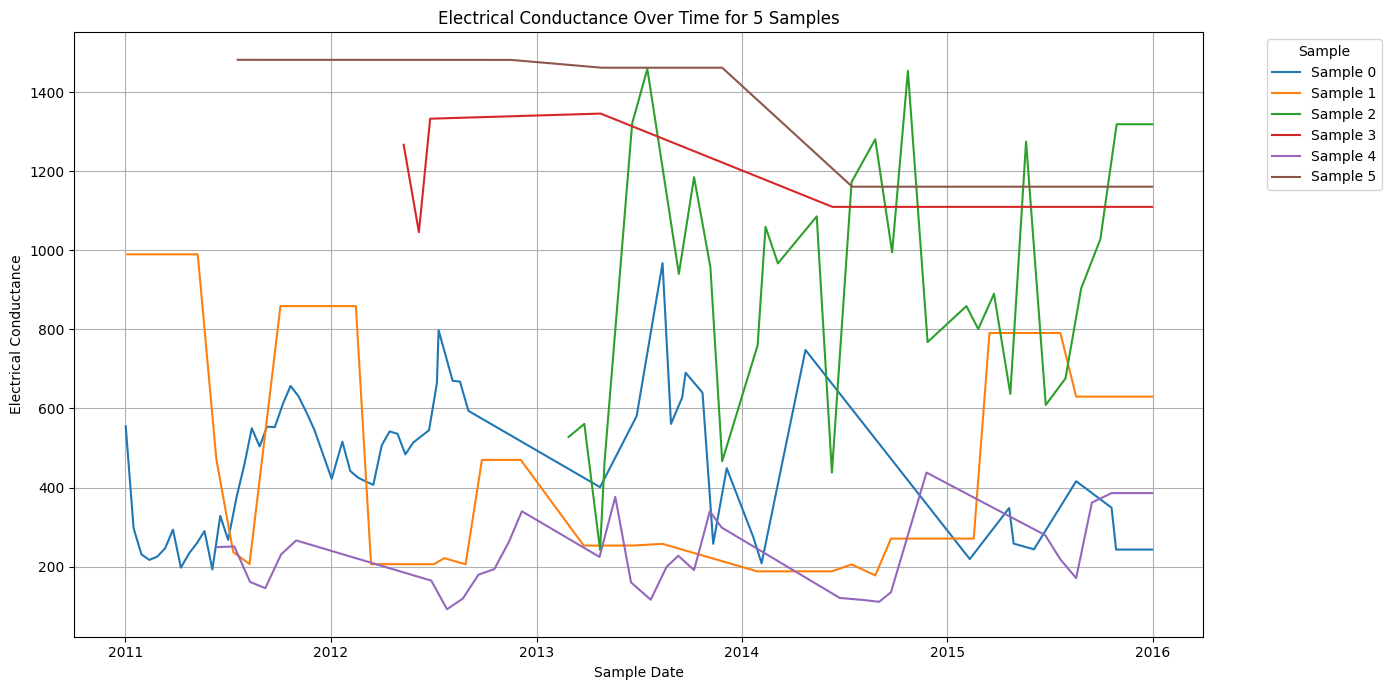

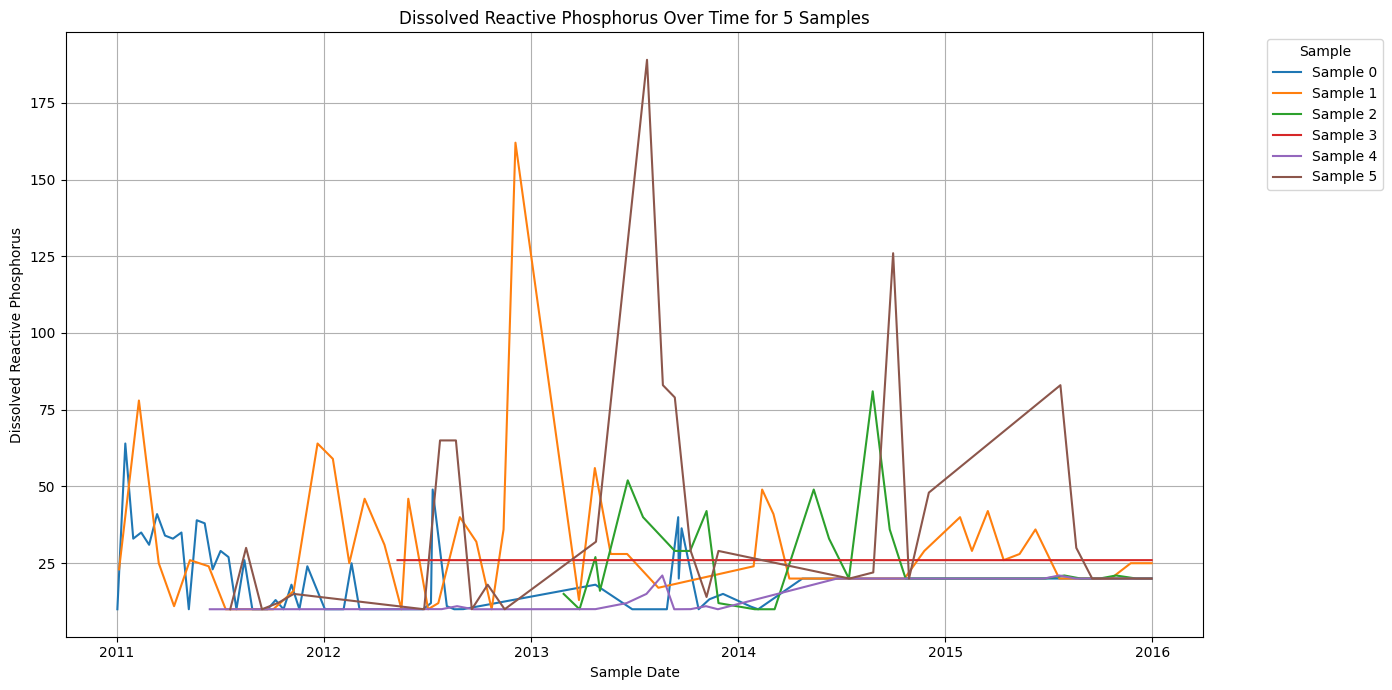

In [181]:
df_seasonal= Water_Quality_df.copy()
df_seasonal["sample_index"] = df_seasonal.groupby(['Longitude', 'Latitude']).ngroup()

df_seasonal["date"] = pd.to_datetime(df_seasonal["Sample Date"], format="%d-%m-%Y")

full_dates = pd.DataFrame(pd.date_range(df_seasonal["date"].min(), df_seasonal["date"].max(), freq="D"), columns=["date"])
full_dates["date"] = pd.to_datetime(full_dates["date"])

predictor_variables = ["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]
num_samples = 5
for predictor_variable in predictor_variables:
    plt.figure(figsize=(14, 7))
    for sample_id in df_seasonal["sample_index"].drop_duplicates().sort_values():
        df_sample_merge = pd.merge(full_dates, df_seasonal[df_seasonal['sample_index']==sample_id], on="date", how="left")
        df_sample_merge['sample_index'] = sample_id
        df_sample_merge[predictor_variable] = df_sample_merge[predictor_variable].interpolate()
        plt.plot(df_sample_merge["date"]
                 , df_sample_merge[predictor_variable]
                 , label=f"Sample {sample_id}"
                 # , alpha=0.8
                 )
        if sample_id == num_samples:
            break

    # plt.ylim(0, 1)
    plt.xlabel("Sample Date")
    plt.ylabel(f"{predictor_variable}")
    plt.title(f"{predictor_variable} Over Time for {num_samples} Samples")
    plt.grid(True)
    plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

## Mean TA, EC & DRP per day over time (Try and identify seasonal variations)

In [218]:
def get_season(dt):
    m = dt.month
    if m in [12, 1, 2]:
        return "Summer"
    if m in [3, 4, 5]:
        return "Autumn"
    if m in [6, 7, 8]:
        return "Winter"
    return "Spring"

seasons = {
    "Summer": "#ffe6e6",
    "Autumn": "#fff2cc",
    "Winter": "#e6f0ff",
    "Spring": "#e6ffe6"
}


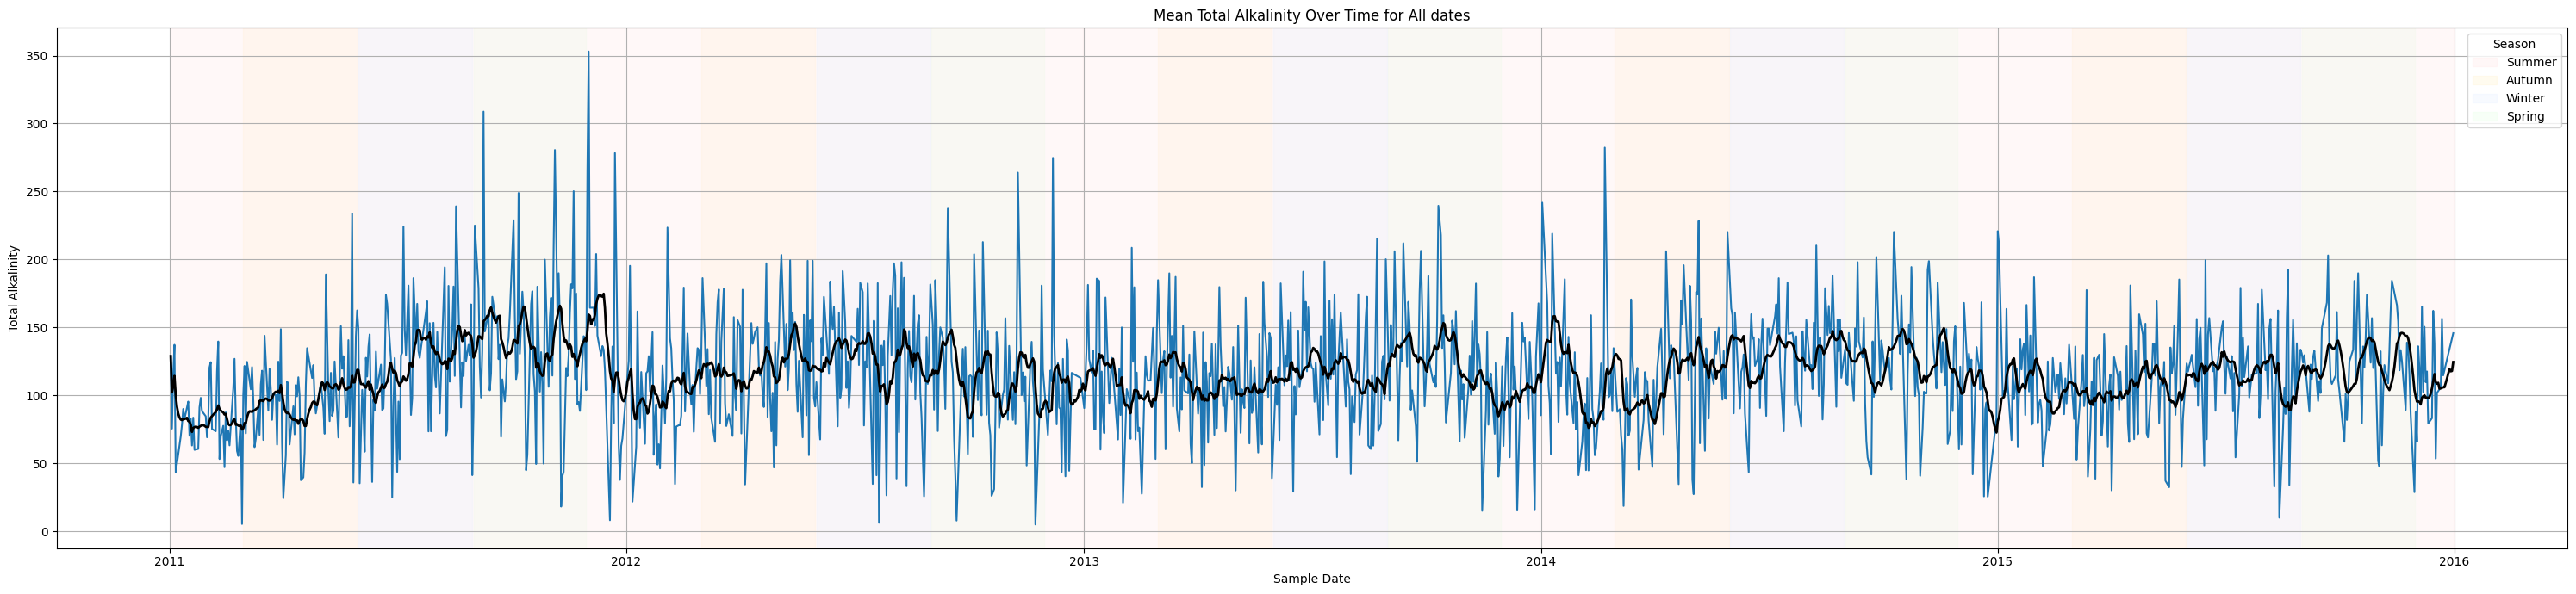

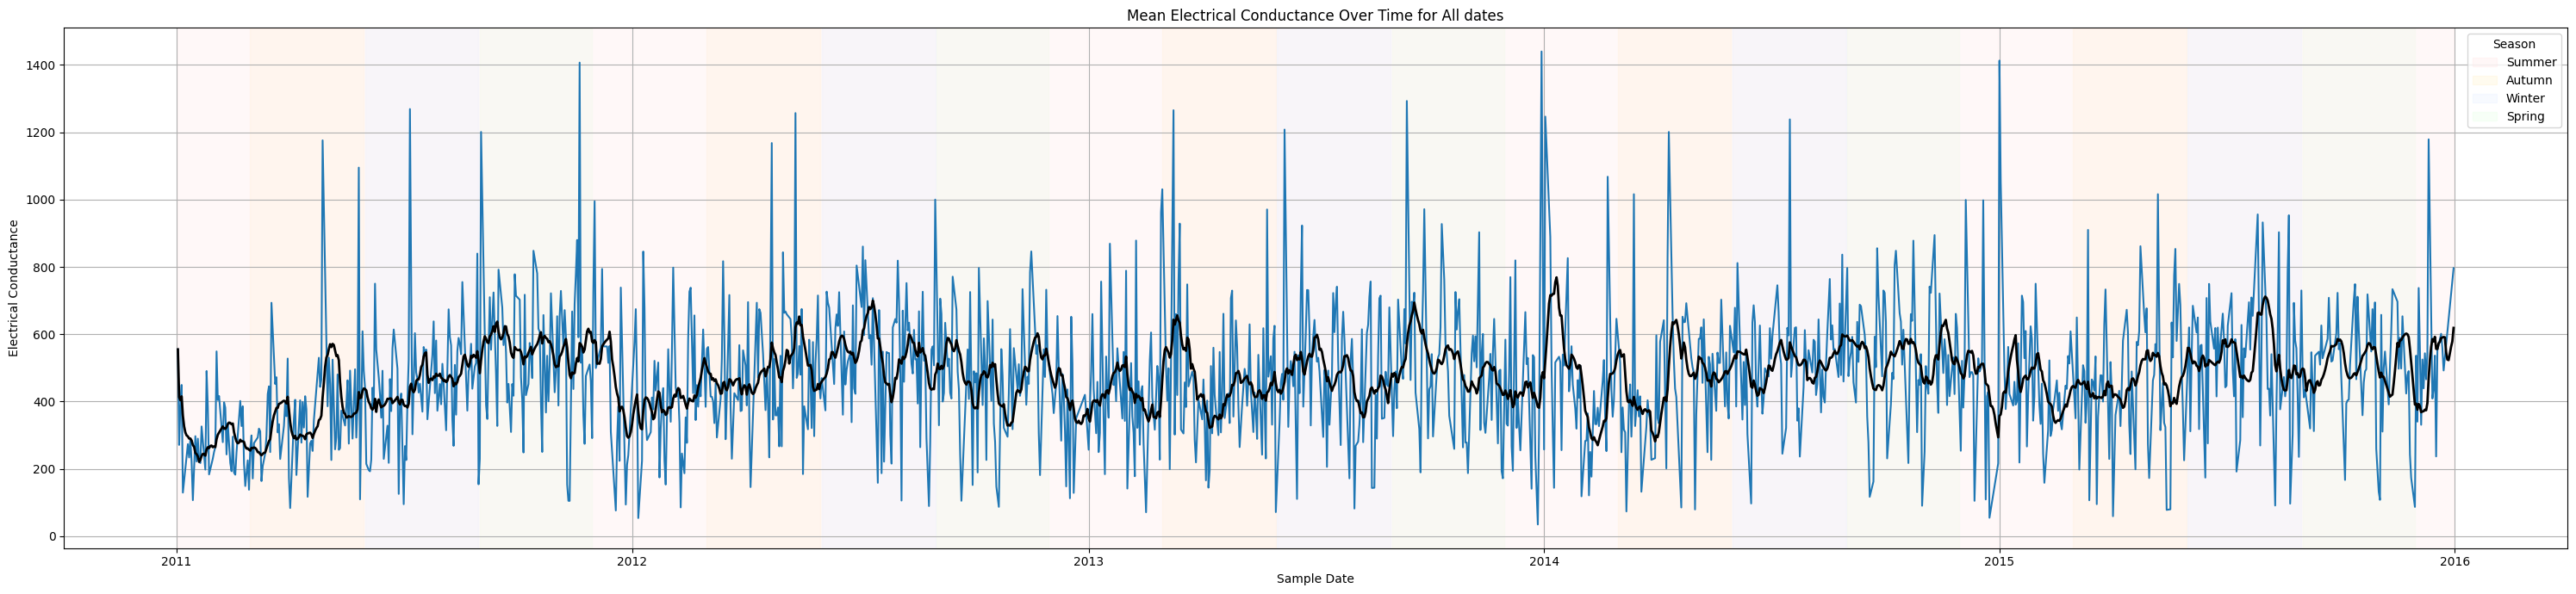

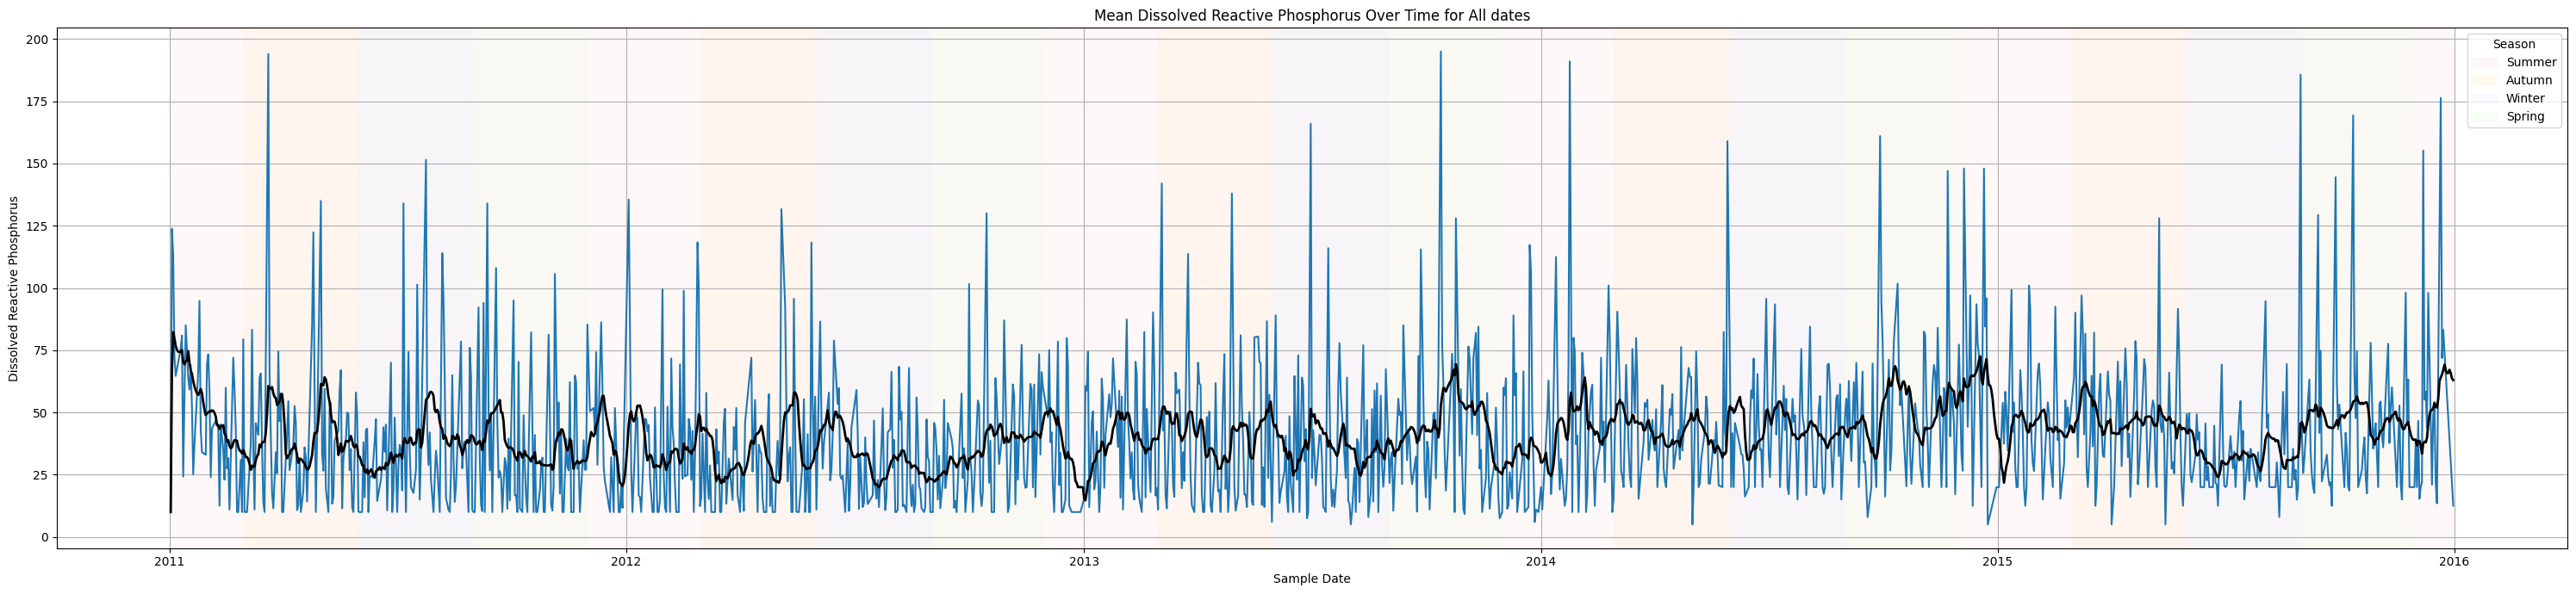

In [226]:
df_seasonal_mean = Water_Quality_df.copy()
df_seasonal_mean = df_seasonal_mean.groupby(['Sample Date']).mean().reset_index().rename(columns={"index": "Sample Date"})

df_seasonal_mean["date"] = pd.to_datetime(df_seasonal_mean["Sample Date"], format="%d-%m-%Y")

full_dates = pd.DataFrame(pd.date_range(df_seasonal_mean["date"].min(), df_seasonal_mean["date"].max(), freq="D"), columns=["date"])
full_dates["date"] = pd.to_datetime(full_dates["date"])

df_sample_merge = pd.merge(full_dates, df_seasonal_mean, on="date", how="left")

predictor_variables = ["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]
for predictor_variable in predictor_variables:
    plt.figure(figsize=(30, 7))
    df_sample_merge[predictor_variable] = df_sample_merge[predictor_variable].interpolate()
    df_sample_merge["season"] = df_sample_merge["date"].apply(get_season)
    df_sample_merge["year"] = df_sample_merge["date"].dt.year

    df_sample_merge["trend"] = df_sample_merge[predictor_variable].rolling(window=14, min_periods=1).mean()

    plt.plot(df_sample_merge["date"]
             , df_sample_merge[predictor_variable]
             , label=predictor_variable
             # , alpha=0.8
             )


    plt.plot(df_sample_merge["date"], df_sample_merge["trend"], color="black", linewidth=2)

    season_ranges = (
        df_sample_merge
        .groupby(["year", "season"])["date"]
        .agg(["min", "max"])
        .reset_index()
    )

    for _, row in season_ranges.iterrows():
        plt.axvspan(
            row["min"],
            row["max"],
            color=seasons[row["season"]],
            alpha=0.25,
            zorder=0,
        )

    patches = [Patch(color=c, alpha=0.3, label=s) for s, c in seasons.items()]

    # plt.ylim(0, 1)
    plt.xlabel("Sample Date")
    plt.ylabel(f"{predictor_variable}")
    plt.title(f"Mean {predictor_variable} Over Time for All dates")
    plt.grid(True)
    # plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.legend(handles=patches, title="Season")
    plt.tight_layout()
    plt.show()


## Mean TA, EC & DRP per day over time (Try and identify seasonal variations) - grouped by Day, Month

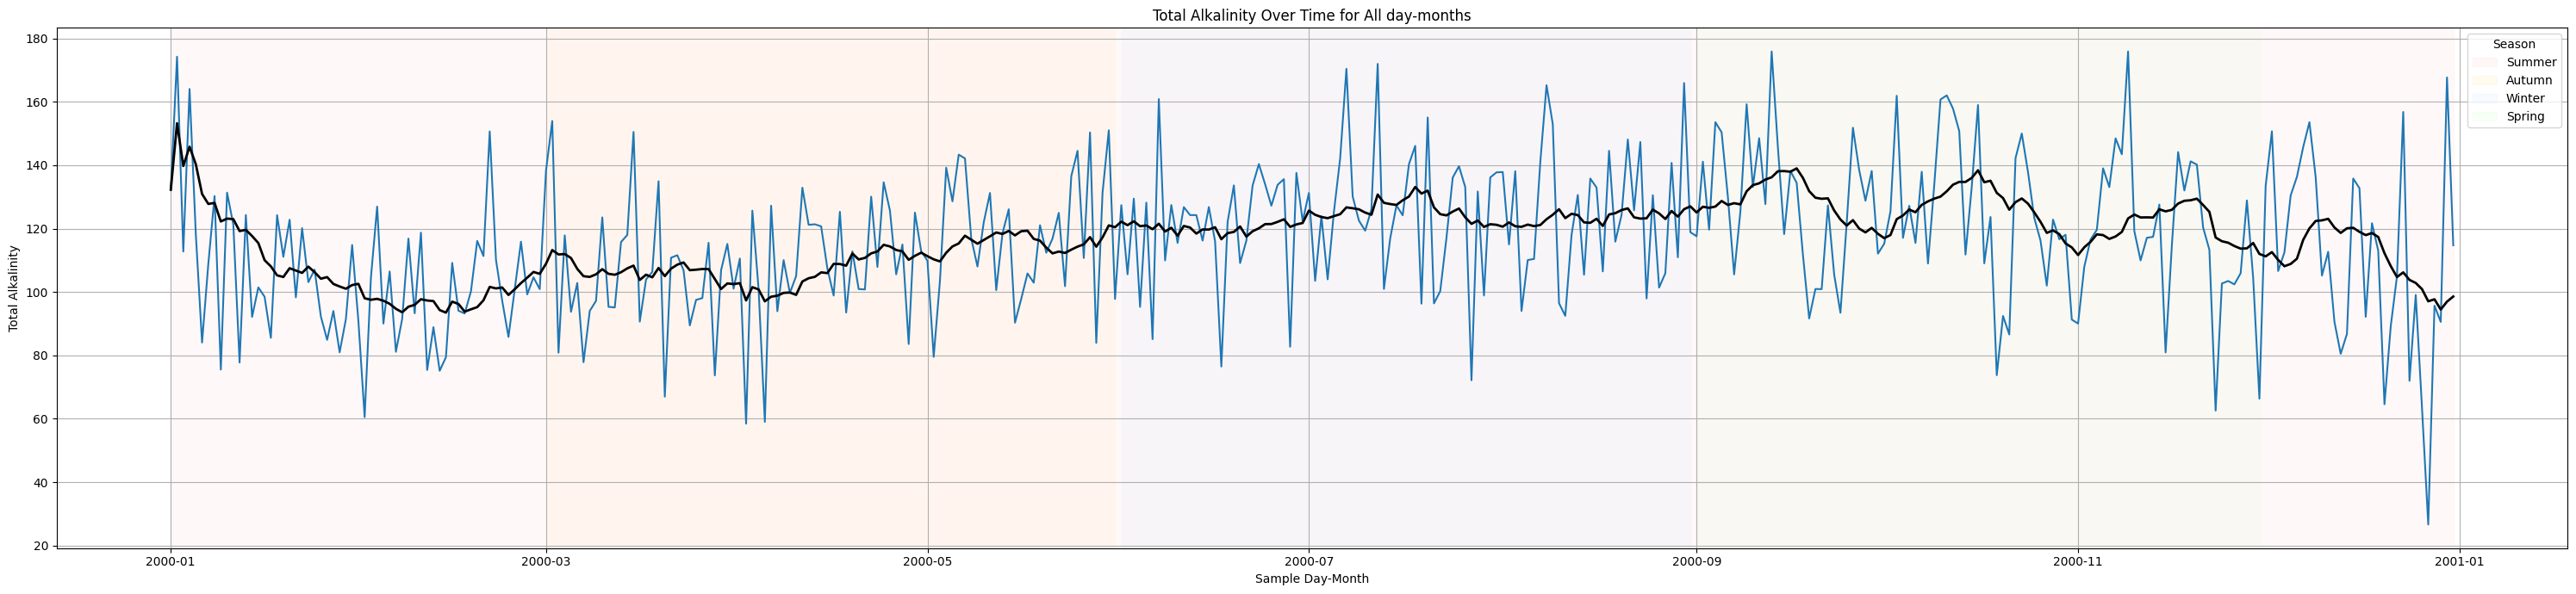

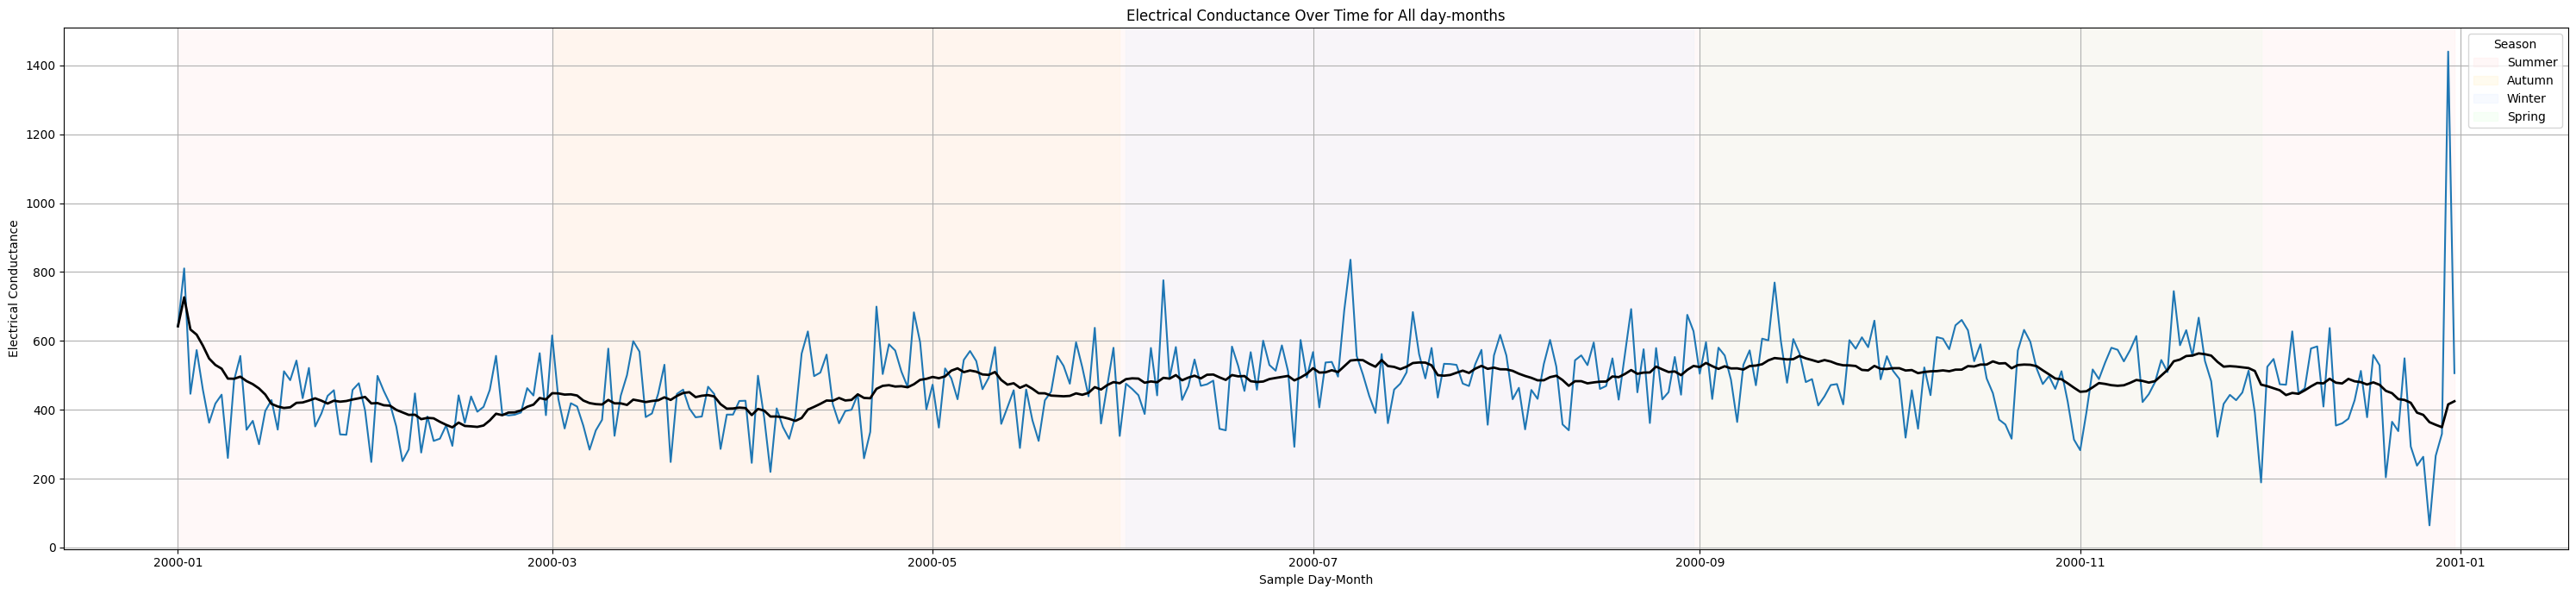

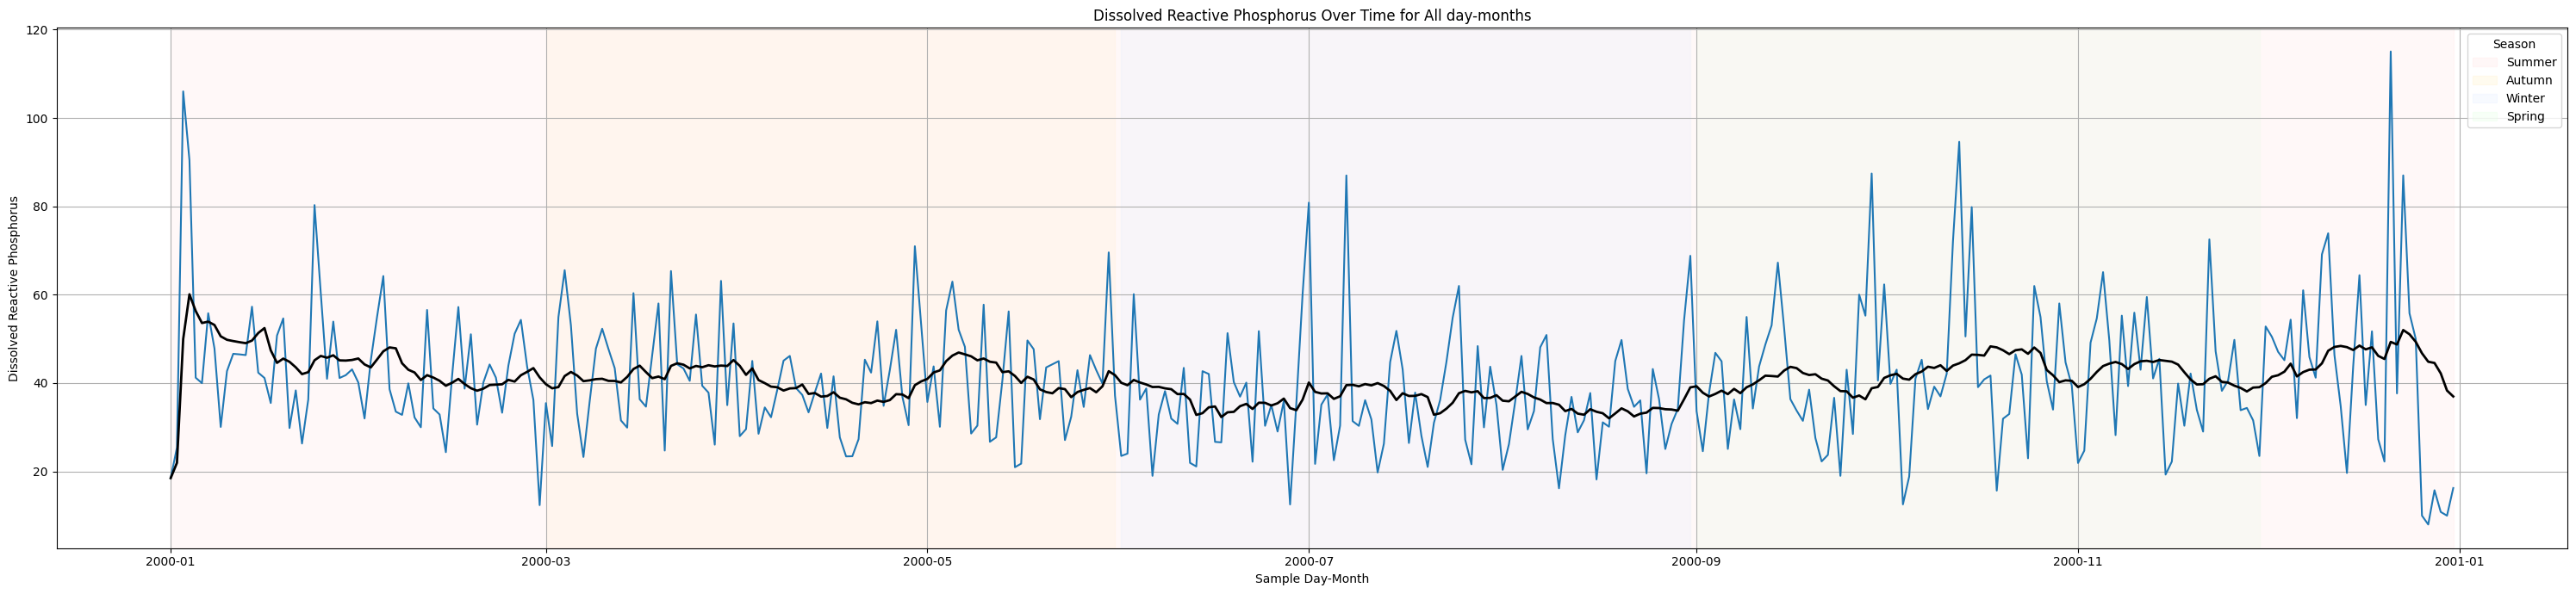

In [230]:
df_seasonal_mean_grp_dm = Water_Quality_df.copy()
df_seasonal_mean_grp_dm = df_seasonal_mean_grp_dm.groupby(['Sample Date']).mean().reset_index().rename(columns={"index": "Sample Date"})

df_seasonal_mean_grp_dm["date"] = pd.to_datetime(df_seasonal_mean_grp_dm["Sample Date"], format="%d-%m-%Y")
df_seasonal_mean_grp_dm["day"] = df_seasonal_mean_grp_dm["date"].dt.day
df_seasonal_mean_grp_dm["month"] = df_seasonal_mean_grp_dm["date"].dt.month
df_seasonal_mean_grp_dm["day_month"] = df_seasonal_mean_grp_dm["date"].dt.strftime("%d-%m")

df_seasonal_mean_grp_dm.drop(columns=["Sample Date", "date"], inplace=True)
df_seasonal_mean_grp_dm = df_seasonal_mean_grp_dm.groupby(["day", "month", "day_month"]).mean().reset_index().sort_values(["month", "day"])
df_seasonal_mean_grp_dm['date'] = df_seasonal_mean_grp_dm["new_date"] = pd.to_datetime(
        dict(year=2000, month=df_seasonal_mean_grp_dm["month"], day=df_seasonal_mean_grp_dm["day"])
    )

full_dates = pd.DataFrame(pd.date_range(df_seasonal_mean_grp_dm["date"].min(), df_seasonal_mean_grp_dm["date"].max(), freq="D"), columns=["date"])
full_dates["date"] = pd.to_datetime(full_dates["date"])

df_sample_merge = pd.merge(full_dates, df_seasonal_mean_grp_dm, on="date", how="left")

predictor_variables = ["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]
for predictor_variable in predictor_variables:
    plt.figure(figsize=(30, 7))
    df_sample_merge[predictor_variable] = df_sample_merge[predictor_variable].interpolate()
    df_sample_merge["season"] = df_sample_merge["date"].apply(get_season)
    df_sample_merge["year"] = df_sample_merge["date"].dt.year

    df_sample_merge["trend"] = df_sample_merge[predictor_variable].rolling(window=14, min_periods=1).mean()

    plt.plot(df_sample_merge["date"]
             , df_sample_merge[predictor_variable]
             , label=predictor_variable
             # , alpha=0.8
             )


    plt.plot(df_sample_merge["date"], df_sample_merge["trend"], color="black", linewidth=2)

    season_ranges = (
        df_sample_merge
        .groupby(["year", "season"])["date"]
        .agg(["min", "max"])
        .reset_index()
    )

    for _, row in season_ranges.iterrows():
        plt.axvspan(
            row["min"],
            row["max"],
            color=seasons[row["season"]],
            alpha=0.25,
            zorder=0,
        )

    patches = [Patch(color=c, alpha=0.3, label=s) for s, c in seasons.items()]


    # plt.ylim(0, 1)
    plt.xlabel("Sample Day-Month")
    plt.ylabel(f"{predictor_variable}")
    plt.title(f"{predictor_variable} Over Time for All day-months")
    plt.grid(True)
    # plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.legend(handles=patches, title="Season")
    plt.tight_layout()
    plt.show()

